## PDS API demo
# Visualization of Osiris-Rex OVIRS spectrometer observations of asteroid BENNU

The purpose of this notebook is to demostrate how the PDS web API can be used to access the PDS data for a scientific use case.

Documention for the PDS web API is available on https://nasa-pds.github.io/pds-api/

Documentation for the `peppi` library used to interface with the PDS web API is available on https://nasa-pds.github.io/peppi/

This notebook is available on https://github.com/NASA-PDS/pds-api-notebook

 
<b>WARNING:</b> This notebook is a demo and not a real scientific use case. It might contain mistakes in the way the data is used or displayed.

In [28]:
from __future__ import print_function
from pprint import pprint, pformat
from IPython.lib.pretty import pretty
import time
import matplotlib.pyplot as plt
from astropy.io import fits

## Access the PDS web API server via peppi

The PDS API can be more easily accessed using `peppi`, a PDS Python client library available from https://nasa-pds.github.io/peppi/

In [29]:
import pds.peppi as pep

Once installed, `peppi` can be used to easily interface with the PDS web API via two objects:

* An instance of the `PDSRegistryClient` class, which handles connections to the PDS web API endpoint
* An instance of the `OrexProducts` class, which is used to assemble and submit user-defined queries on the PDS API for the mission OSIRIS-REx.

In [30]:
# The PDSRegistryClient class requires no arguments, and is configured with appropriate defaults to communicate with 
# the production PDS Registry API.
client = pep.PDSRegistryClient()

# A Products class instance requires a PDSRegistryClient object that is uses to submit user-defined queries.
# Results from a query are obtained by iterating over a Products class instance after a query has been defined.
products = pep.OrexProducts(client)

## Use `peppi` to Get observations around specific spot (lat=12, lon=24) with distance to Bennu closer than 4 km


We use the `has_target` query clause to locate products target LIDVID "urn:nasa:pds:context:target:asteroid.101955_bennu".

We also use the `has_instrument` query clause to further filter resulting products to "urn:nasa:pds:context:instrument:ovirs.orex" instrument.

Further refinement is made on the obervations being closer than 4.0 km from Bennu and targetting a specific location, within a bounding box.

Note that the implementation of the `within_range` and `within_bbox` methods implies using mission specific parameters. 

In [41]:
# TODO: identify a way for the user to know which properties can be selected
# see ticket https://github.com/NASA-PDS/peppi/issues/78
properties_of_interest = ['ref_lid_target', 
                          'ref_lid_instrument', 
                          'orex:Spatial.orex:latitude', 
                          'orex:Spatial.orex:longitude', 
                          'orex:Spatial.orex:target_range', 
                          'ops:Data_File_Info.ops:file_ref']

# TODO add has_instrument OVIR
products.has_target("urn:nasa:pds:context:target:asteroid.101955_bennu") \
        .within_bbox(9.0, 15.0, 21.0, 27.0) \
        .within_range(4.0) \
        .fields(properties_of_interest) # optional, improves performance by 30%,  
                                        # 2s instead of 3 to download the data




## Load the FITS data files

Using the astropy.fits module


In [32]:
hduls = []

start_time = time.time()

# Read in data, skipping any unreachable links
for p in products:
    try:
        data_file = p.properties['ops:Data_File_Info.ops:file_ref'][0]
        # discrepency between registry (version 10.0) and what is actually available in SBN node (version 11.0)
        data_file = data_file.replace("v10_0", "v11_0")
        requests.get(data_file).raise_for_status()
    except HTTPError as err:
        if err.response.status_code == 404:
            # Some URLs may be dead links, in which case just skip them
            continue
        else:
            # Something else went wrong
            raise
            
    hduls.append(fits.open(data_file))
    
elapsed = time.time() - start_time

print(f"The product selection and data download took {elapsed} seconds" )


The product selection and data download took 3.2010059356689453 seconds


## Plot the spectrometer data

/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/loubrieu/PycharmProjects/search-api-notebook/venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **

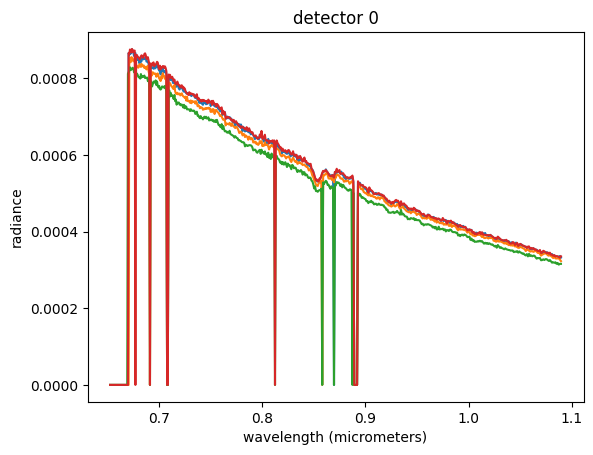

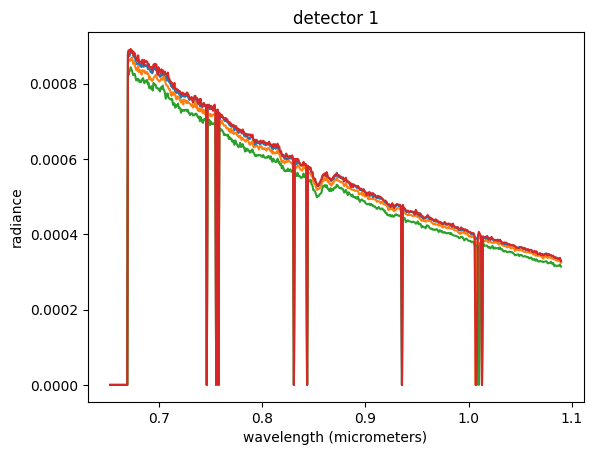

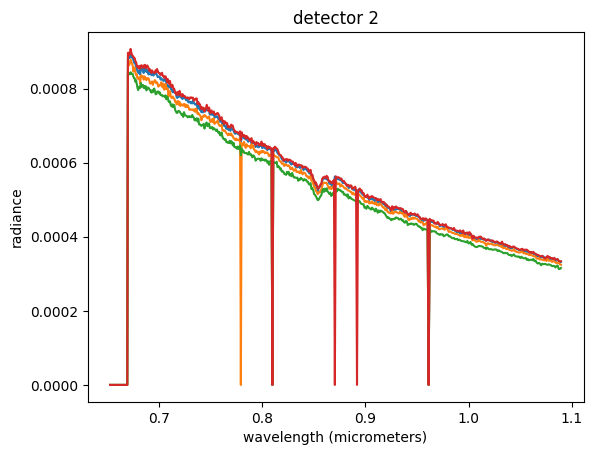

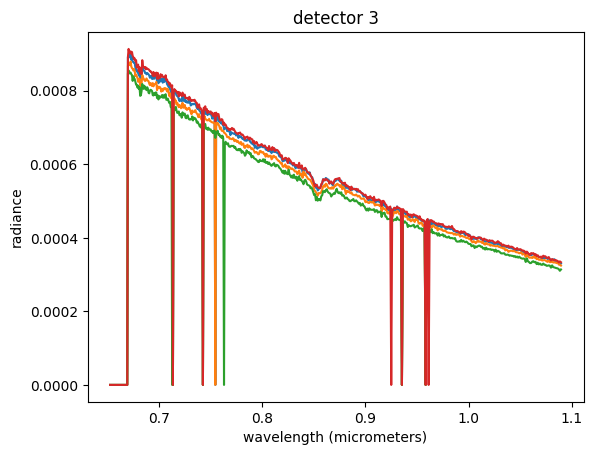

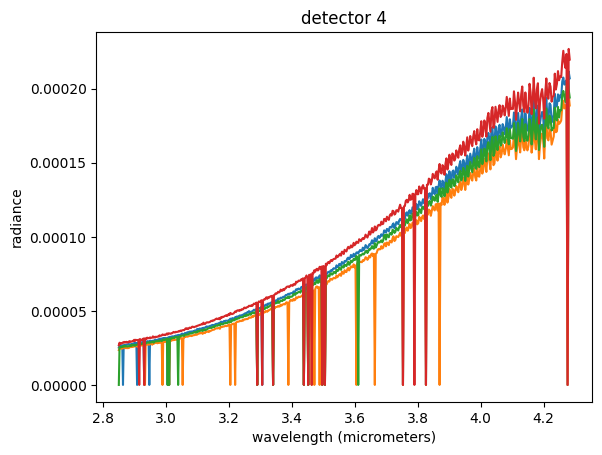

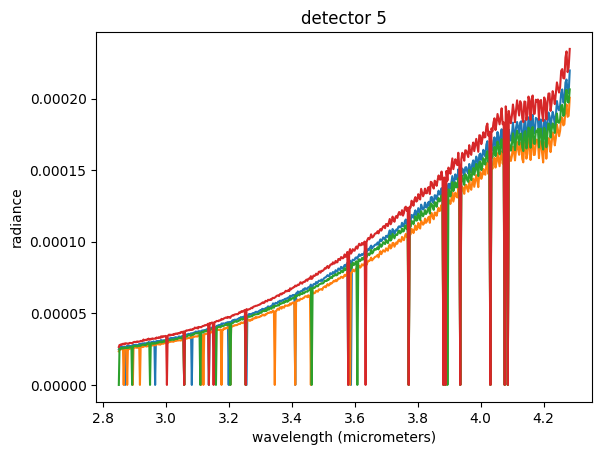

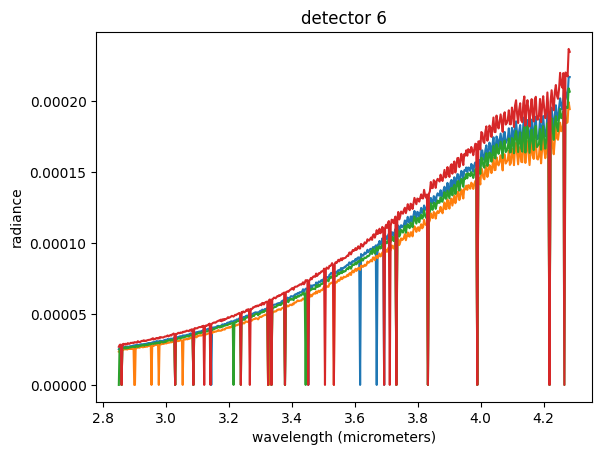

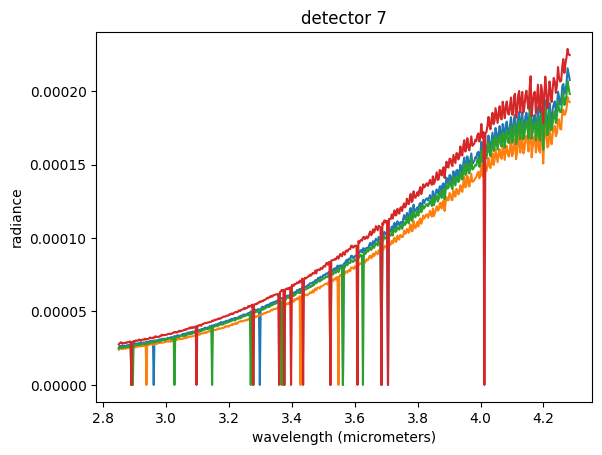

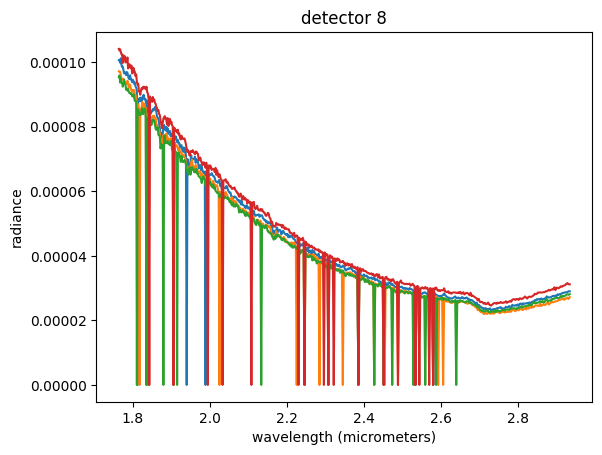

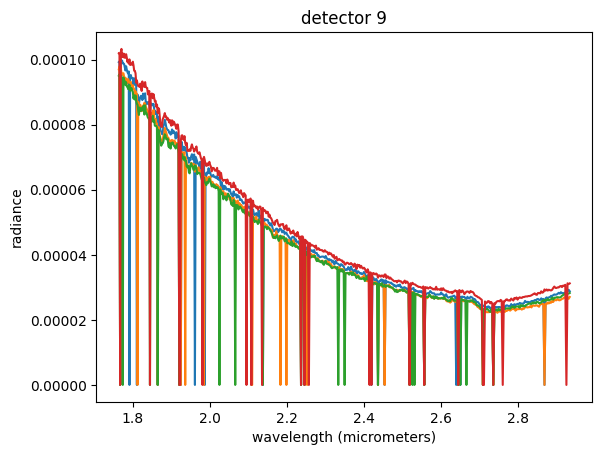

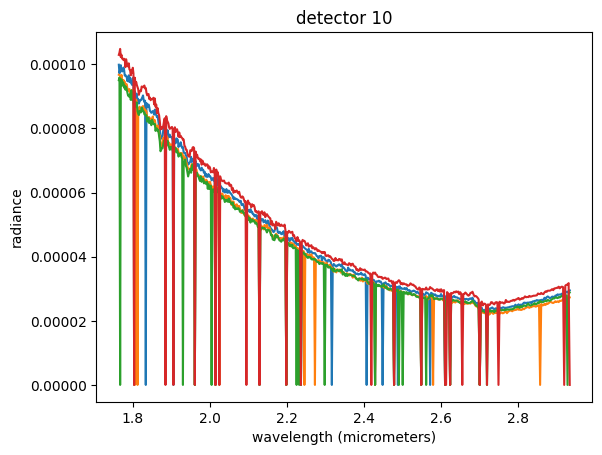

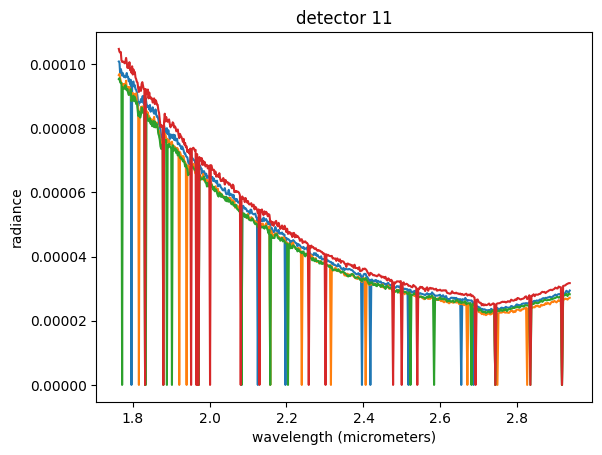

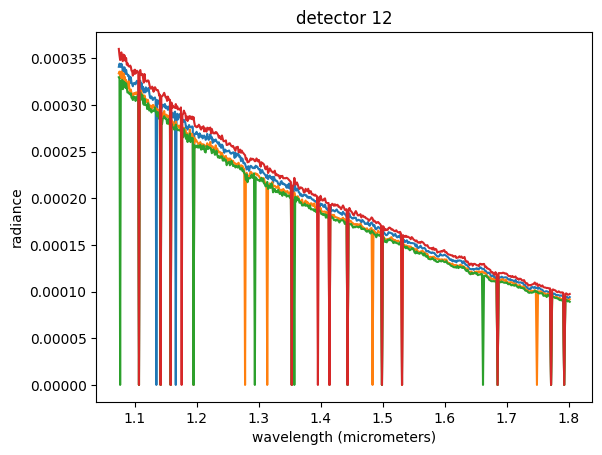

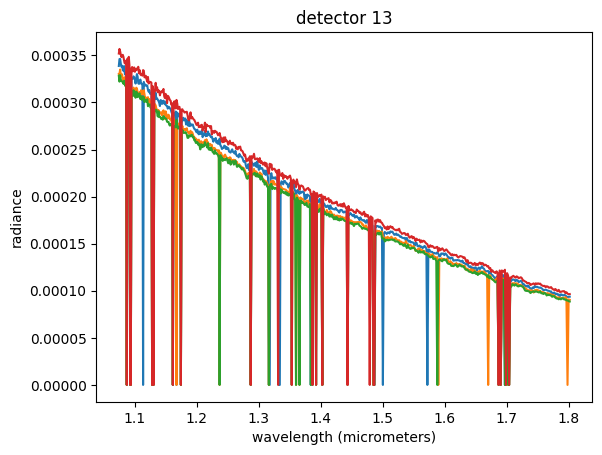

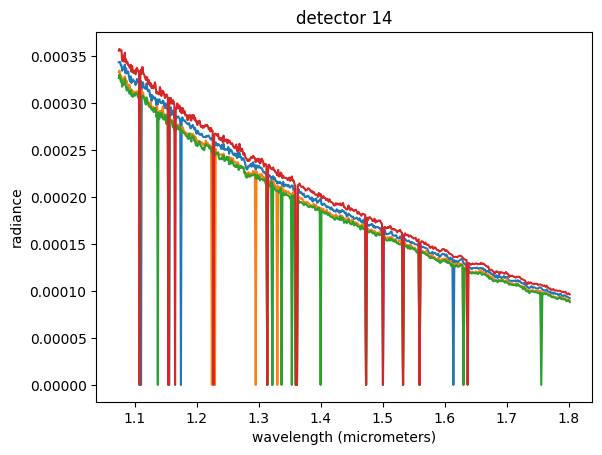

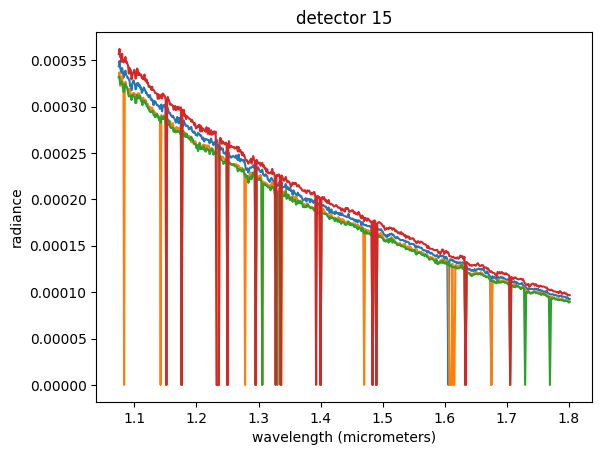

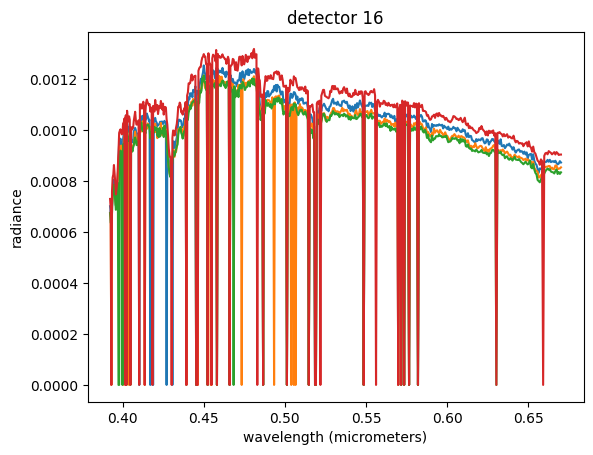

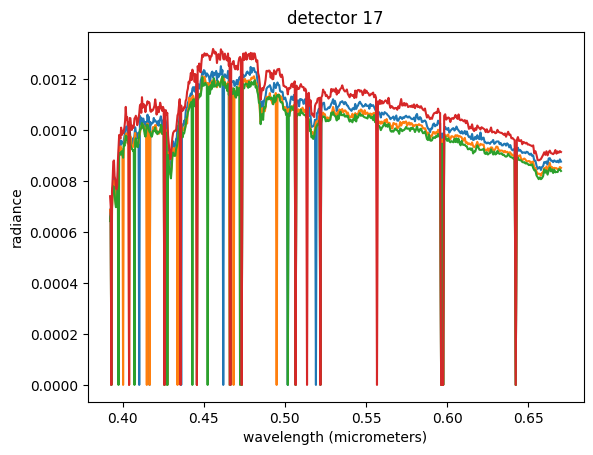

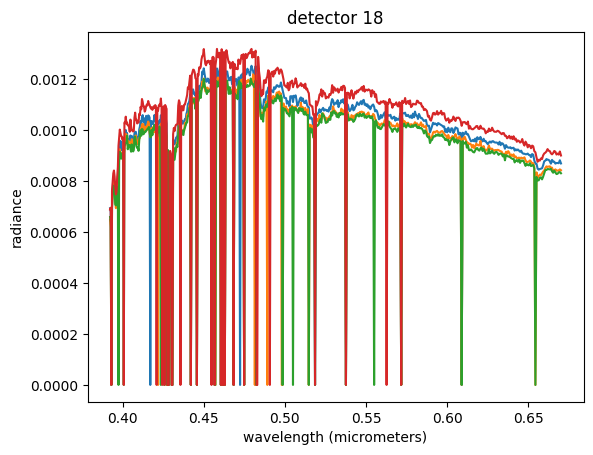

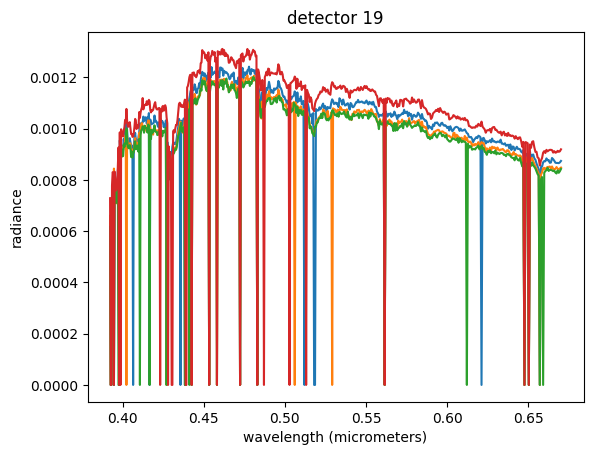

In [22]:
for i in range(20): # for each dimension of the instrument
    fig, ax = plt.subplots()
    ax.set_title(f'detector {i}')
    for hdul in hduls: # for each observation
        ax.plot(hdul[2].data[0, i, :], hdul[0].data[0, i, :])
    ax.set_xlabel('wavelength (micrometers)')
    ax.set_ylabel('radiance')